In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

In [6]:
from pathlib import Path

# Resolve project root (works regardless of notebook kernel cwd)
def get_project_root():
    p = Path.cwd()
    for _ in range(6):
        if (p / "environment.yml").exists() or (p / "README.md").exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return Path.cwd()

PROJECT_ROOT = get_project_root()
DATA_DIR = PROJECT_ROOT / "data" / "processed"

gdelt = pd.read_csv(DATA_DIR / "gdelt_articles_accumulated.csv", parse_dates=["seendate"])
ohlcv = pd.read_csv(DATA_DIR / "prices_daily_accumulated.csv", parse_dates=["date"])


In [8]:
# Installs vaderSentiment if not already installed
import sys
!{sys.executable} -m pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [10]:
print("Shape:", gdelt.shape)
print("Null titles:", gdelt["title"].isna().sum())
print("Unique tickers:", sorted(gdelt["ticker"].unique()))

if "title_clean" not in gdelt.columns:
    gdelt["title_clean"] = gdelt["title"].fillna("").astype(str)

analyzer = SentimentIntensityAnalyzer()

# create sentiment_compound if missing
gdelt["sentiment_compound"] = gdelt["title_clean"].apply(
    lambda t: analyzer.polarity_scores(t)["compound"])


avg_sentiment_by_ticker = (gdelt.groupby("ticker")["sentiment_compound"].mean().round(4).sort_values(ascending=False))
avg_sentiment_by_ticker


Shape: (1406, 10)
Null titles: 0
Unique tickers: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']


ticker
GOOGL    0.1443
AAPL     0.1390
MSFT     0.1183
AMZN     0.0938
META     0.0893
NVDA     0.0407
TSLA     0.0217
Name: sentiment_compound, dtype: float64

## Assumption
Most news headlines covering MAG7 companies will be classified as having a neutral sentiment by VADER due to its limitations in detecting nuances in speech.

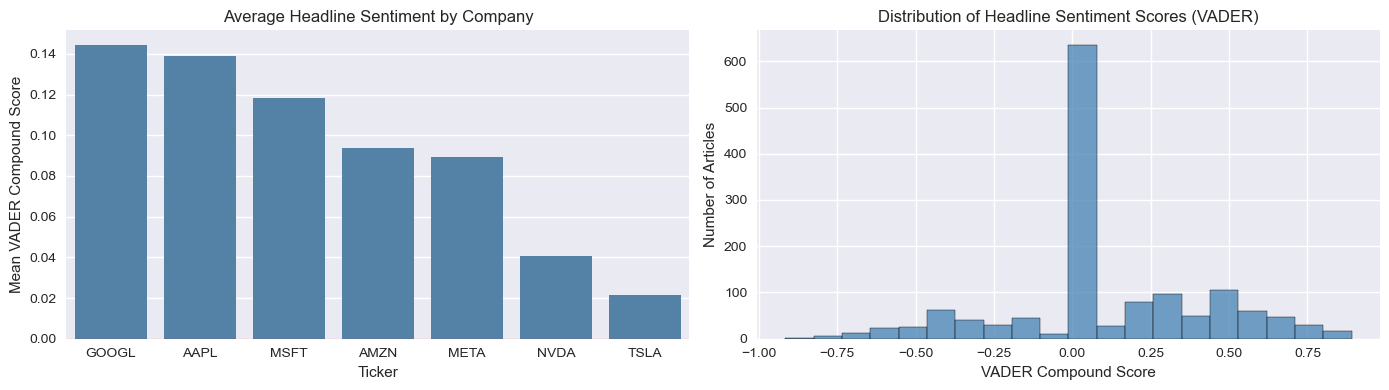

In [11]:
fig, (avg_sent_plt, sent_dist) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(14, 4)
)

# Bar chart - Average sentiment by company

sns.barplot(
    x=avg_sentiment_by_ticker.index,
    y=avg_sentiment_by_ticker.values,
    ax=avg_sent_plt,
    color="steelblue"
)

avg_sent_plt.set_title("Average Headline Sentiment by Company")
avg_sent_plt.set_ylabel("Mean VADER Compound Score")
avg_sent_plt.set_xlabel("Ticker")
avg_sent_plt.tick_params(axis="x", rotation=0)
avg_sent_plt.axhline(0, color="red", linewidth=0.8)

# Histogram - Sentiment Distribution
sns.histplot(
    gdelt["sentiment_compound"],
    bins=20,
    ax=sent_dist,
    color="steelblue",
    edgecolor="black"
)

sent_dist.set_title("Distribution of Headline Sentiment Scores (VADER)")
sent_dist.set_xlabel("VADER Compound Score")
sent_dist.set_ylabel("Number of Articles")

plt.tight_layout()
plt.show()

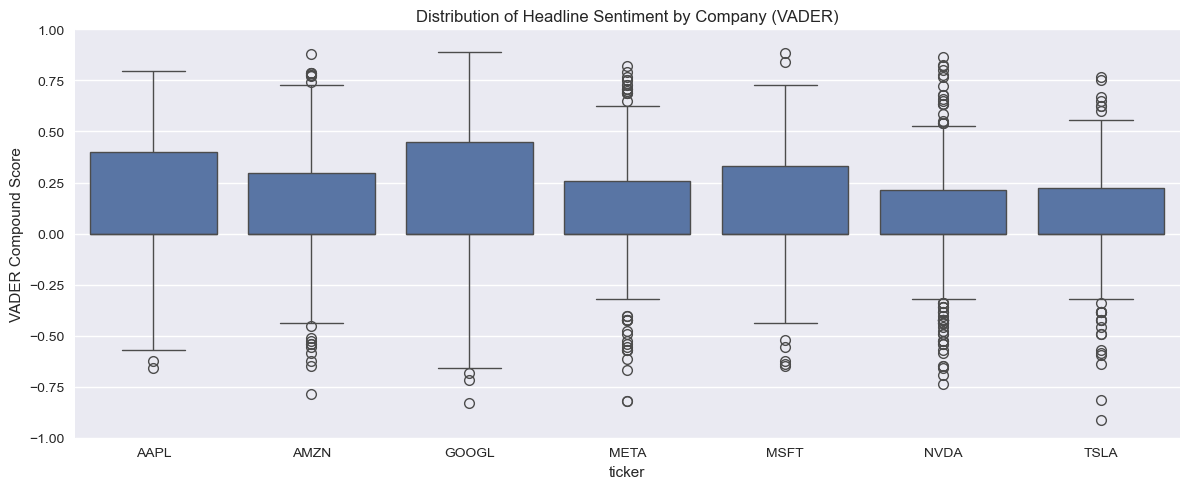

In [12]:
# Box Plot - Distribution of sentiment across MAG7 tickers
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=gdelt, x="ticker", y="sentiment_compound", order=sorted(gdelt["ticker"].unique()), ax=ax)
ax.set_title("Distribution of Headline Sentiment by Company (VADER)")
ax.set_ylabel("VADER Compound Score")
ax.set_ylim(-1, 1)
plt.tight_layout()
plt.show()



In [ ]:
# Fraction of neutral headlines by company
neutral_by_ticker = (
    gdelt.assign(is_neutral=gdelt["sentiment_compound"].eq(0))
         .groupby("ticker")["is_neutral"].mean().sort_values(ascending=False)
)

print("Fraction of neutral headlines by ticker:")
print(neutral_by_ticker.apply(lambda x: f"{x:.2%}").to_string())



Fraction of neutral headlines by ticker:
ticker
META     50.00%
TSLA     46.43%
MSFT     44.57%
NVDA     44.03%
AAPL     42.19%
GOOGL    37.63%
AMZN     37.42%


In [51]:
# Quartiles of sentiment scores by ticker
quartiles = (
    gdelt.groupby("ticker")["sentiment_compound"].quantile([0.25, 0.50, 0.75]).unstack()
    )
quartiles.columns = ["25th percentile", "Median (50th)", "75th percentile"]

print("Sentiment quartiles by ticker:")
print(quartiles.to_string())


Sentiment quartiles by ticker:
        25th percentile  Median (50th)  75th percentile
ticker                                                 
AAPL                0.0            0.0           0.4019
AMZN                0.0            0.0           0.2960
GOOGL               0.0            0.0           0.4496
META                0.0            0.0           0.2558
MSFT                0.0            0.0           0.3291
NVDA                0.0            0.0           0.2144
TSLA                0.0            0.0           0.2242


**Immediate Observations**
- Headline sentiment scores produced by VADER are heavily concentrated at neutral values (compound = 0) across all MAG7 tickers.
- Lower quartile and median sentiment at zero for all tickers, indicating that at least half of headlines are classified as neutral.
- Differences between companies emerge primarily in the upper quartile of the distribution when using VADER.